## Imports

In [1]:
%run mask_to_submission # This generates dummy_submission.csv which is needed to import submission_to_mask w/o errors

training/groundtruth/satImage_001.png
training/groundtruth/satImage_002.png
training/groundtruth/satImage_003.png
training/groundtruth/satImage_004.png
training/groundtruth/satImage_005.png
training/groundtruth/satImage_006.png
training/groundtruth/satImage_007.png
training/groundtruth/satImage_008.png
training/groundtruth/satImage_009.png
training/groundtruth/satImage_010.png
training/groundtruth/satImage_011.png
training/groundtruth/satImage_012.png
training/groundtruth/satImage_013.png
training/groundtruth/satImage_014.png
training/groundtruth/satImage_015.png
training/groundtruth/satImage_016.png
training/groundtruth/satImage_017.png
training/groundtruth/satImage_018.png
training/groundtruth/satImage_019.png
training/groundtruth/satImage_020.png
training/groundtruth/satImage_021.png
training/groundtruth/satImage_022.png
training/groundtruth/satImage_023.png
training/groundtruth/satImage_024.png
training/groundtruth/satImage_025.png
training/groundtruth/satImage_026.png
training/gro

In [2]:
from mask_to_submission import *
from submission_to_mask import *

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams
%matplotlib inline

from IPython.display import Image
%load_ext autoreload
%autoreload 2

## Exploratory data analysis

### Training images and ground truth
#### Just a peek at what the data looks like

In [3]:
rcParams['figure.figsize'] = 11 ,8

img_train_1 = mpimg.imread('training/images/satImage_001.png')
img_gt_1 = mpimg.imread('training/groundtruth/satImage_001.png')

fig, ax = plt.subplots(1,2)

ax[0].imshow(img_train_1)
ax[0].title.set_text('Train image 1')
ax[1].imshow(img_gt_1, cmap="gray")
ax[1].title.set_text('Groundtruth 1')

### Split image into patches

In [ ]:
sub_image_1 = img_train_1[200:216, 200:216]
sub_image_2 = img_train_1[240:256, 260:276]
fig, ax = plt.subplots(1,2)

ax[0].imshow(sub_image_1)
ax[0].title.set_text('Train subimage 1, road')
ax[1].imshow(sub_image_2)
ax[1].title.set_text('Train subimage 2, not road')

#### Basically we cannot train on independent 16x16 images, we need to train on the whole image/a bigger patch.

#### As we only have 100 train images, we can split those images into patches of a smaller size. Size is restricted to a multiple of 16 (for the submission) that must divide 400 (image length and width)

In [ ]:
def split_into_patches(img, patchsize):
    assert patchsize % 16 == 0 and 400 % patchsize == 0, "Invalid patchsize. Must be in {16, 80, 400}."
    sub_images = []
    width = img.shape[0]
    height = img.shape[1]
    for x in range(width // patchsize):
        for y in range(height // patchsize):
            tlc = (x*patchsize, y*patchsize) # Top left corner
            sub_images.append(img[tlc[0]:tlc[0]+patchsize,tlc[1]:tlc[1]+patchsize])
    return np.array(sub_images)

#### Demonstration

In [ ]:
patchsize = 80
si = split_into_patches(img_train_1, patchsize)

fig, ax = plt.subplots(5,5) # Works for patchsize = 80
for i in range(5):
    for j in range(5):
        ax[i,j].imshow(si[5*i + j])

#### Same can be applied to ground truth

In [ ]:
patchsize = 80
si = split_into_patches(img_gt_1, patchsize)

fig, ax = plt.subplots(5,5) # Works for patchsize = 80
for i in range(5):
    for j in range(5):
        ax[i,j].imshow(si[5*i + j], cmap="gray")

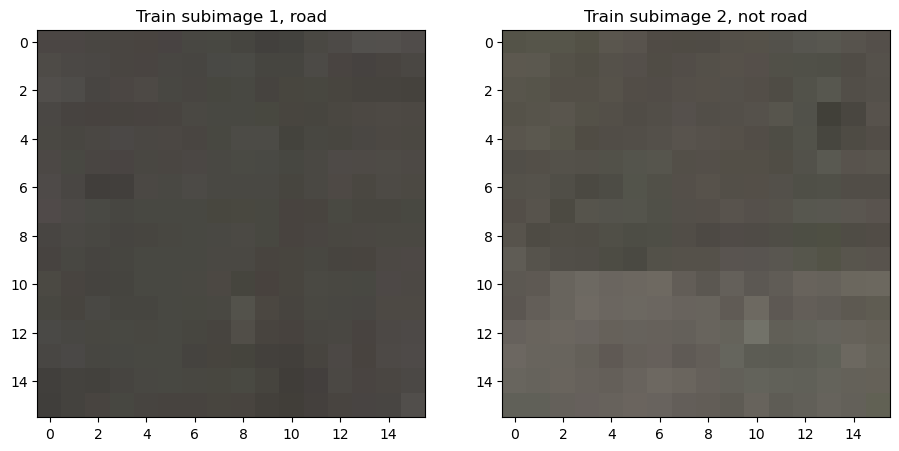

In [14]:
subA = img_A[200:216, 200:216]
subA2 = img_A[240:256, 260:276]
fig, ax = plt.subplots(1,2)

ax[0].imshow(subA)
ax[0].title.set_text('Train subimage 1, road')
ax[1].imshow(subA2)
ax[1].title.set_text('Train subimage 2, not road')
# so basically we cannot train on independent 16x16 images, we need to train on the whole image probably